In [21]:
from modules.building_data import get_tile, osmbuildings_request, receive_building_data, tile_bbox

In [92]:
from modules.building_data import get_all_tiles, get_all_tile_jsons, get_tiles, get_split_coords
from modules.building_data import is_polygon_point_inside, is_polygon_inside, get_clipped_polygon_area, get_building_coverage
from modules.building_data import plot_pixel_and_polygons, get_split_coords 

In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
import numpy as np
import matplotlib.pyplot as plt
import mpmath as mp
import requests
import pandas as pd
import warnings
from shapely.geometry import Polygon
from modules.clipper import PolygonClipper
from ast import literal_eval
import json

In [26]:
paris_df = pd.read_csv("../data/processed_data/Paris/Paris.csv")

In [27]:
paris_df.head()

,LST,ele,LST_diff,ele_diff,ul_corner,ll_corner,lr_corner,ur_corner,bb
0,28.489990,45.577310,-2.315979,-28.184334,"[[2.2633263464873545, 48.81321032181281]]","[[2.2633263464873545, 48.813839888049166]]","[[2.2639559127237074, 48.813839888049166]]","[[2.2639559127237074, 48.81321032181281]]","[[2.2633263464873545, 48.81321032181281], [2.2..."
1,28.549988,45.577430,-2.255981,-28.184212,"[[2.2639559127237074, 48.81321032181281]]","[[2.2639559127237074, 48.813839888049166]]","[[2.2645854789600603, 48.813839888049166]]","[[2.2645854789600603, 48.81321032181281]]","[[2.2639559127237074, 48.81321032181281], [2.2..."
2,28.450012,46.947140,-2.355957,-26.814503,"[[2.2645854789600603, 48.81321032181281]]","[[2.2645854789600603, 48.813839888049166]]","[[2.2652150451964133, 48.813839888049166]]","[[2.2652150451964133, 48.81321032181281]]","[[2.2645854789600603, 48.81321032181281], [2.2..."
3,29.230011,48.411680,-1.575958,-25.349964,"[[2.2652150451964133, 48.81321032181281]]","[[2.2652150451964133, 48.813839888049166]]","[[2.265844611432766, 48.813839888049166]]","[[2.265844611432766, 48.81321032181281]]","[[2.2652150451964133, 48.81321032181281], [2.2..."
4,27.889984,48.643574,-2.915985,-25.118069,"[[2.265844611432766, 48.81321032181281]]","[[2.265844611432766, 48.813839888049166]]","[[2.266474177669119, 48.813839888049166]]","[[2.266474177669119, 48.81321032181281]]","[[2.265844611432766, 48.81321032181281], [2.26..."


In [8]:
paris_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35028 entries, 0 to 35027
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LST        35028 non-null  float64
 1   ele        35028 non-null  float64
 2   LST_diff   35028 non-null  float64
 3   ele_diff   35028 non-null  float64
 4   ul_corner  35028 non-null  object 
 5   ll_corner  35028 non-null  object 
 6   lr_corner  35028 non-null  object 
 7   ur_corner  35028 non-null  object 
 8   bb         35028 non-null  object 
dtypes: float64(4), object(5)
memory usage: 2.4+ MB


In [28]:
paris_df['test'] = paris_df['bb'].copy()

In [29]:
paris_df['test'] = paris_df.test.apply(literal_eval)

In [11]:
type(paris_df.test[0])

list

In [ ]:
# paris_df.bb.apply(lambda x: x.)

In [ ]:
# paris_df['test'] = paris_df['test'].replace('[]', '')

In [ ]:
# paris_df.bb.apply(lambda x: x.)

In [30]:
clip = PolygonClipper(warn_if_empty=False)

In [82]:
def get_building_clipped_area(building_coords, clip, pixel):
    clipped = clip(building_coords, pixel)
    pgon = Polygon(clipped)
    area = pgon.area
    return area

In [32]:
def is_building_inside(building_coords, pixel):
    inside=True
    for coord in building_coords:
        if pixel[0][0] < coord[0] < pixel[2][0] and pixel[0][1] < coord[1] < pixel[1][1]:
            pass
        else:
            inside = False
    return inside

In [53]:
def is_point_inside(building_coords, pixel):
    inside=False
    for coord in building_coords:
        if pixel[0][0] < coord[0] < pixel[2][0] and pixel[0][1] < coord[1] < pixel[1][1]:
            inside = True
        else:
            continue
    return inside

In [80]:
def get_building_coverage(buildings, clip, pixel):
    separate_areas = []
    for building in buildings:
        building_coords = building[1]
        if is_building_inside(building_coords, pixel):
            pgon = Polygon(building_coords)
            separate_areas.append(pgon.area)
        elif is_point_inside(building_coords, pixel):
            area = get_building_clipped_area(building_coords, clip, pixel)
            separate_areas.append(area)
    built_area = np.sum(separate_areas)
    pixel_poly = Polygon(pixel)
    pixel_area = pixel_poly.area
    prop_area_built = built_area/pixel_area
    return prop_area_built

In [50]:
# def get_building_coverage(buildings, clip, pixel):
#     separate_areas = []
#     for building in buildings:
#         building_coords = building[1]
#         try:
#             area = get_building_clipped_area(building, clip, pixel)
#             separate_areas.append(area)
#             print('building area added')
#         except:
#             if is_building_inside(building_coords, pixel):
#                 pgon = Polygon(building_coords)
#                 separate_areas.append(pgon.area)
#                 print('building area added')
#     built_area = np.sum(separate_areas)
#     print(f'The separate areas are {separate_areas}')
#     print(f'the total built area is{built_area}')
#     pixel_poly = Polygon(pixel)
#     pixel_area = pixel_poly.area
#     prop_area_built = built_area/pixel_area
#     print(f'the proportional area is {prop_area_built}')
#     return prop_area_built

In [17]:
paris_coords = {'upper_left': [48.813898, 2.264216],
                'lower_right': [48.900502, 2.42172]}

In [34]:
f = open('/home/matt/code/b-fa-ce/future_proofing_cities/data/building_data_raw.json')
paris_jsons = json.load(f)
paris_buildings = receive_building_data(paris_jsons)

In [35]:
paris_buildings[0]

[3,
 [[2.264284, 48.80854],
  [2.264271, 48.808532],
  [2.264219, 48.808564],
  [2.264237, 48.808584],
  [2.264256, 48.808572],
  [2.264245, 48.808564],
  [2.264284, 48.80854]]]

In [16]:
single_pixel = paris_df['test'][0]

In [40]:
single_pixel

[[2.2633263464873545, 48.81321032181281],
 [2.2633263464873545, 48.813839888049166],
 [2.2639559127237074, 48.813839888049166],
 [2.2639559127237074, 48.81321032181281]]

In [87]:
building_density = get_building_coverage(paris_buildings, clip, single_pixel)

In [88]:
building_density

0.027406419466892006

In [32]:
test_set = paris_df['test'][:10]

In [89]:
building_densities = [get_building_coverage(paris_buildings, clip, pixel) for pixel in test_set]

In [90]:
building_densities

[0.027406419466892006,
 0.09271208456622948,
 0.06005162768672451,
 0.004278246729816333,
 0.01312244811213052,
 0.017363859450119708,
 0.03459807158376528,
 0.010080973420051632,
 0.047053275099517414,
 0.05453027720990245]

In [ ]:
[0.027406419466892006,
 0.00861925398265395,
 0.06005162768672451,
 0.004278246729816333,
 0.01312244811213052,
 0.017363859450119708,
 0.03459807158376528,
 0.010080973420051632,
 0.047053275099517414,
 0.05453027720990245]

In [39]:
# paris_df['building_density'] = paris_df.test.apply(lambda x : get_building_coverage(paris_buildings, clip, x))

In [47]:
type(paris_buildings[0][1][0][0])

float

In [46]:
type(single_pixel[0][0])

float

In [36]:
def get_matching_buildings(buildings, pixel):
    local_buildings = []
    for building in buildings:
        coords = building[1]
        for point in coords:
            if pixel[0][0] < point[0] < pixel[2][0] and pixel[0][1] < point[1] < pixel[1][1]:
                local_buildings.append(building)
                continue
    return local_buildings

In [ ]:
def get_pixel_polygons(polygons, pixel):
    local_polygons = []
    for polygon in polygons:
        for point in coords:
            if is_polygon_inside(polygon, pixel):
                local_polygons.append(polygon)
                continue
            elif is_polygon_point_inside(polygon, pixel):
                local_polygons.append(polygon)
                continue
    return local_polygons

In [53]:
matching_buildings = get_matching_buildings(paris_buildings, single_pixel)

In [37]:
def split_x_y(coords):
    x = []
    y = []
    for coord in coords:
        x.append(coord[0])
        y.append(coord[1])
    return x, y

In [38]:
def plot_buildings_pixel(buildings, pixel):
    pixel_returning = pixel.copy()
    pixel_returning.append(pixel[0])
    x, y = split_x_y(pixel_returning)
    plt.plot(x, y)
    for building in buildings:
        building_coords = building[1]
        x, y = split_x_y(building_coords)
        plt.plot(x, y)

In [61]:
troublesome_pixel = paris_df['test'][1]

In [62]:
matching_buildings2 = get_matching_buildings(paris_buildings, single_pixel)

In [72]:
x, y = split_x_y(single_pixel)
x2, y2 = split_x_y(troublesome_pixel)
print(x, y)

[2.2633263464873545, 2.2633263464873545, 2.2639559127237074, 2.2639559127237074] [48.81321032181281, 48.813839888049166, 48.813839888049166, 48.81321032181281]


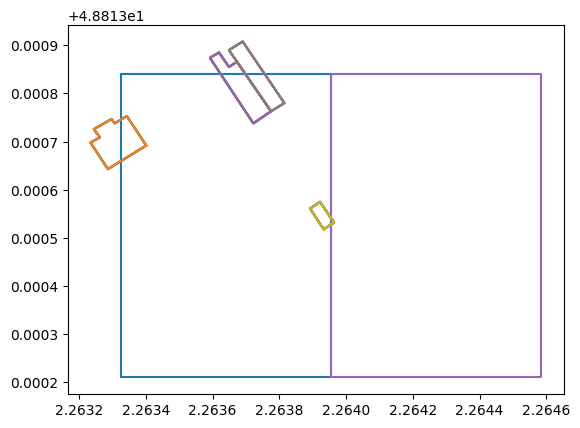

In [102]:
plot_buildings_pixel(matching_buildings, single_pixel)
plot_buildings_pixel(matching_buildings2, troublesome_pixel)

In [ ]:
def visualise_buildings_pixel(pixels, buildings, number, clip):
    chosen_pixel = pixels[number]
    matching_buidlings = get_matching_buildings(buildings, chosen_pixel)
    plot_pixel_and_polygons(matching_buidlings, chosen_pixel)
    coverage = get_building_coverage(buildings, clip, chosen_pixel)
    plt.title(f"Building coverage is {round(coverage, 3)}%.")
    plt.show()

In [ ]:
def visualise_landuse_pixel(pixels, landuse_polygons, number, clip):
    chosen_pixel = pixels[number]
    matching_buidlings = get_matching_buildings(landuse_polygons, chosen_pixel)
    plot_pixel_and_polygons(matching_buidlings, chosen_pixel)
    coverage = get_landuse_coverage(landuse_polygons, clip, chosen_pixel)
    plt.title(f"Landuse coverage is {round(coverage, 3)}%.")
    plt.show()

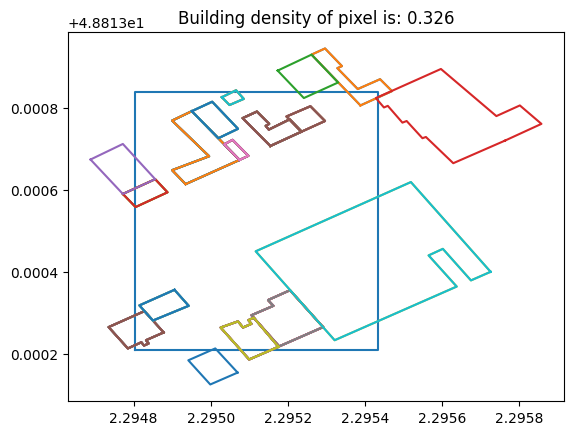

In [90]:
test_pixel = paris_df['test'][50]
matching_buildings3 = get_matching_buildings(paris_buildings, test_pixel)
plot_buildings_pixel(matching_buildings3, test_pixel)
building_density = get_building_coverage(paris_buildings, clip, test_pixel)
plt.title(f"Building density of pixel is: {round(building_density, 3)}")
plt.show;

In [75]:
get_building_coverage(paris_buildings, clip, test_pixel)

building area added
[[ 2.32628297 48.81321032]
 [ 2.32628297 48.81325036]
 [ 2.326299   48.813308  ]
 [ 2.326421   48.813293  ]
 [ 2.32641    48.813252  ]
 [ 2.32659    48.81323   ]
 [ 2.326597   48.813255  ]
 [ 2.326725   48.813239  ]
 [ 2.32671714 48.81321032]]
building area added
[[ 2.32628297 48.81382072]
 [ 2.326357   48.81381   ]
 [ 2.326348   48.813783  ]
 [ 2.326454   48.813767  ]
 [ 2.326445   48.813741  ]
 [ 2.326704   48.813702  ]
 [ 2.326711   48.813726  ]
 [ 2.326831   48.813709  ]
 [ 2.326822   48.813686  ]
 [ 2.32691254 48.81367177]
 [ 2.32691254 48.81358364]
 [ 2.32641    48.813658  ]
 [ 2.326414   48.813669  ]
 [ 2.326362   48.813677  ]
 [ 2.326314   48.813684  ]
 [ 2.32631    48.813672  ]
 [ 2.32628297 48.81367586]]
building area added
The separate areas are [1.7385000000503564e-09, 2.1750947623159142e-08, 6.3790826022354e-08]
the total built area is8.72802736455635e-08
the proportional area is 0.22020807563097083


0.22020807563097083

In [54]:
crossing_buildings = []
for building in paris_buildings:
    building_coords = building[1]
    if is_point_inside(building_coords, test_pixel) and not is_building_inside(building_coords, test_pixel):
        crossing_buildings.append(building_coords)

In [62]:
first

[[2.326425, 48.813118],
 [2.326429, 48.813131],
 [2.326379, 48.813137],
 [2.326374, 48.813124],
 [2.326252, 48.813139],
 [2.326299, 48.813308],
 [2.326421, 48.813293],
 [2.32641, 48.813252],
 [2.32659, 48.81323],
 [2.326597, 48.813255],
 [2.326725, 48.813239],
 [2.326708, 48.813177],
 [2.326699, 48.813178],
 [2.326694, 48.813159],
 [2.32676, 48.813151],
 [2.326728, 48.81303],
 [2.326412, 48.813067],
 [2.326425, 48.813118]]

In [78]:
first = crossing_buildings[0]
area_first_test = get_building_clipped_area(first, clip, test_pixel)


[[ 2.32628297 48.81321032]
 [ 2.32628297 48.81325036]
 [ 2.326299   48.813308  ]
 [ 2.326421   48.813293  ]
 [ 2.32641    48.813252  ]
 [ 2.32659    48.81323   ]
 [ 2.326597   48.813255  ]
 [ 2.326725   48.813239  ]
 [ 2.32671714 48.81321032]]


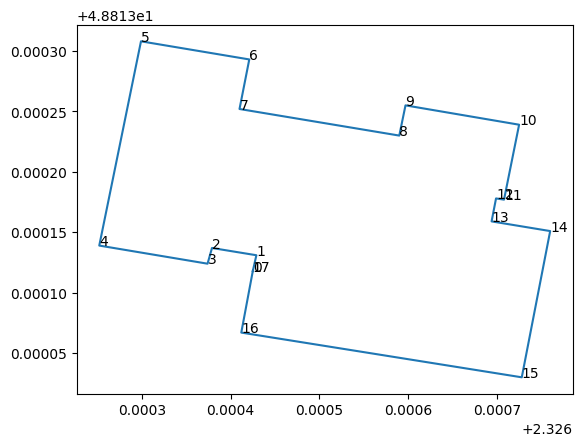

In [65]:
xs, ys = split_x_y(first)
fig, ax = plt.subplots()
ax.plot(xs, ys)
for i in range(len(xs)):
    ax.annotate(i, (xs[i], ys[i]))
plt.show;


In [89]:
test_pixel.append(test_pixel[50])
x_pixel, y_pixel = split_x_y(test_pixel)
fig, ax = plt.subplots()
ax.plot(x_pixel, y_pixel)
for i in range(len(x_pixel)):
    ax.annotate(i, (x_pixel[i], y_pixel[i]))
plt.show;

IndexError: list index out of range

In [71]:
clip = PolygonClipper(warn_if_empty=True)
clipped = clip(first, test_pixel[:-1])
print(clipped)

[[ 2.32628297 48.81321032]
 [ 2.32628297 48.81325036]
 [ 2.326299   48.813308  ]
 [ 2.326421   48.813293  ]
 [ 2.32641    48.813252  ]
 [ 2.32659    48.81323   ]
 [ 2.326597   48.813255  ]
 [ 2.326725   48.813239  ]
 [ 2.32671714 48.81321032]]


In [105]:
# paris_df['building_density'] = paris_df['test'].apply(lambda x: get_building_coverage(paris_buildings, clip, x))